In [1]:
%pip install yfinance pandas numpy matplotlib scikit-learn torch

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

In [3]:
import torch
print(torch.cuda.is_available())
print(torch.cuda.device_count())  # Número de GPUs detectadas
print(torch.cuda.get_device_name(0))  # Nome da primeira GPU

True
1
NVIDIA GeForce RTX 4060 Laptop GPU


In [27]:
# Baixar dados
ticker = "VALE"  # Exemplo: Apple
data = yf.download(ticker, start="2010-01-01", end="2024-11-23")
cols = data.columns
print(data.head())
print(cols)

[*********************100%***********************]  1 of 1 completed

Price       Adj Close      Close       High        Low       Open    Volume
Ticker           VALE       VALE       VALE       VALE       VALE      VALE
Date                                                                       
2010-01-04  13.323681  30.250000  30.280001  29.530001  29.590000  19384000
2010-01-05  13.464625  30.570000  31.020000  30.090000  30.139999  24200200
2010-01-06  13.680443  31.059999  31.430000  30.459999  30.570000  24190900
2010-01-07  13.720087  31.150000  31.170000  30.570000  31.020000  16064900
2010-01-08  13.865433  31.480000  31.879999  31.270000  31.379999  14727200
MultiIndex([('Adj Close', 'VALE'),
            (    'Close', 'VALE'),
            (     'High', 'VALE'),
            (      'Low', 'VALE'),
            (     'Open', 'VALE'),
            (   'Volume', 'VALE')],
           names=['Price', 'Ticker'])


In [ ]:
data = data[['Close']]  # Usar somente o preço de fechamento
data.rename(columns={'Close': 'price'}, inplace=True)

# Visualizar os dados
print(data.head())

In [11]:
# Normalização dos dados
scaler = MinMaxScaler(feature_range=(0, 1))
data['normalized_price'] = scaler.fit_transform(data[['price']])

# Criar sequências de treino
def create_sequences(data, lookback, future_steps=[1, 2, 5, 15]):
    sequences, targets = [], []
    for i in range(len(data) - lookback - max(future_steps)):
        seq = data[i:i + lookback]
        target = [data[i + lookback + step] for step in future_steps]
        sequences.append(seq)
        targets.append(target)
    return np.array(sequences), np.array(targets)

lookback = 365 * 2  # 3 anos
future_steps = [1, 2, 5, 15]
sequences, targets = create_sequences(data['normalized_price'].values, lookback, future_steps)

# Dividir em treino e teste
train_size = int(len(sequences) * 0.8)
X_train, X_test = sequences[:train_size], sequences[train_size:]
y_train, y_test = targets[:train_size], targets[train_size:]

print("Forma de X_train:", X_train.shape)  # (n_samples, lookback)
print("Forma de y_train:", y_train.shape)  # (n_samples, n_steps)

Forma de X_train: (2403, 730)
Forma de y_train: (2403, 4)


In [17]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, dropout=0.2, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        # Pegar apenas a última saída
        last_output = lstm_out[:, -1, :]  # Último passo de tempo
        # Aplicar dropout na última saída
        last_output = self.dropout(last_output)
        # Passar pela camada final
        output = self.fc(last_output)
        return output

# Configurações do modelo
input_size = 1  # Preço normalizado
hidden_size = 70
output_size = len(future_steps)
num_layers = 2
model = LSTMModel(input_size, hidden_size, output_size)

c:\Users\marce\Desktop\PosTech\TC_4\venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


In [18]:
# Configurar dispositivo (GPU ou CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Dispositivo usado: {device}")

Dispositivo usado: cuda


In [19]:
# Mover o modelo para o dispositivo
model = LSTMModel(input_size, hidden_size, output_size, num_layers=num_layers).to(device)

# Conversão para tensores e transferência para o dispositivo
X_train_tensor = torch.FloatTensor(X_train).unsqueeze(-1).to(device)
y_train_tensor = torch.FloatTensor(y_train).to(device)

X_test_tensor = torch.FloatTensor(X_test).unsqueeze(-1).to(device)
y_test_tensor = torch.FloatTensor(y_test).to(device)

# Treinamento
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epochs = 70
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f'Época [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

Época [10/70], Loss: 0.0197
Época [20/70], Loss: 0.0165
Época [30/70], Loss: 0.0154
Época [40/70], Loss: 0.0125
Época [50/70], Loss: 0.0061
Época [60/70], Loss: 0.0041
Época [70/70], Loss: 0.0029


Loss no conjunto de teste: 0.0009


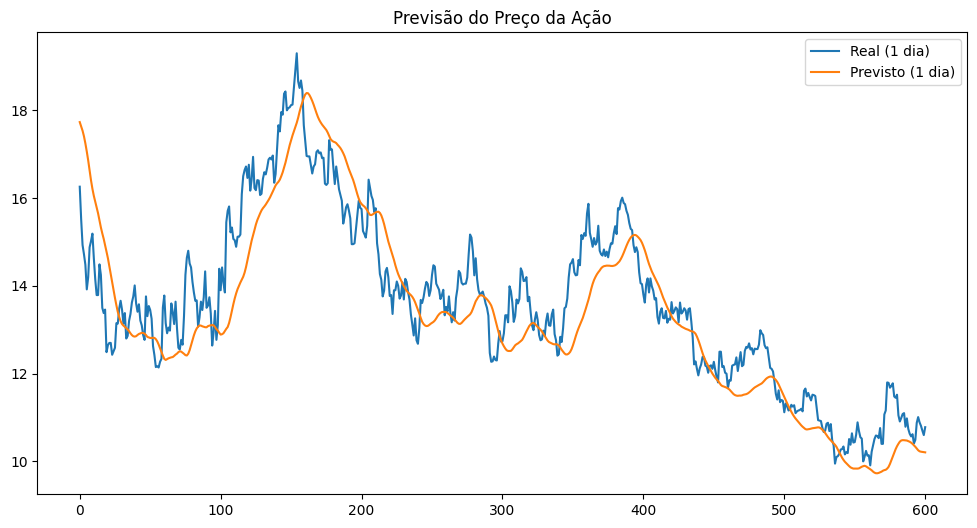

In [20]:
model.eval()
with torch.no_grad():
    predictions = model(X_test_tensor)
    loss = criterion(predictions, y_test_tensor)
    print(f"Loss no conjunto de teste: {loss.item():.4f}")

# Reverter a normalização para os valores reais
predictions = scaler.inverse_transform(predictions.cpu().numpy())
y_test_real = scaler.inverse_transform(y_test)

# Comparar valores reais e previstos
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(y_test_real[:, 0], label="Real (1 dia)")
plt.plot(predictions[:, 0], label="Previsto (1 dia)")
plt.title("Previsão do Preço da Ação")
plt.legend()
plt.show()

In [21]:
# Avaliar o modelo
model.eval()  # Modo de avaliação
with torch.no_grad():
    predictions = model(X_test_tensor)  # Previsões no conjunto de teste

# Reverter normalização das previsões e dos valores reais
predictions_real = scaler.inverse_transform(predictions.cpu().numpy())
y_test_real = scaler.inverse_transform(y_test)

# Calcular métricas
def mean_absolute_percentage_error(y_true, y_pred):
    """Calcula o erro percentual absoluto médio (MAPE)."""
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# MAE
mae = mean_absolute_error(y_test_real, predictions_real)

# RMSE
rmse = np.sqrt(mean_squared_error(y_test_real, predictions_real))

# MAPE
mape = mean_absolute_percentage_error(y_test_real, predictions_real)

# Exibir resultados
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Square Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

Mean Absolute Error (MAE): 0.82
Root Mean Square Error (RMSE): 1.06
Mean Absolute Percentage Error (MAPE): 5.83%
